# Test the API

## Host the API

You first need to host the API.
To do so, you can use the following commands:

```bash
# build the docker image if you haven't already
docker build -t muffin_vs_chihuahua_api .

# run the docker image
docker run -p 8000:8000 muffin_vs_chihuahua_api
```

## Prepare the Environment

In [1]:
# dependencies
from pathlib import Path
import requests
from collections import namedtuple

# data structures
Muffin = namedtuple(
    "Muffin",
    ["a", "b", "c", "d"]
)

Chihuahua = namedtuple(
    "Chihuahua",
    ["a", "b", "c", "d"]
)

In [2]:
# endpoint of your API
url = "http://localhost:8000/predict"

# paths
DATA_DIR = Path("../data/processed/test")
MUFFINS = DATA_DIR / "muffin"
CHIHUAHUAS = DATA_DIR / "chihuahua"

# example images
muffin = Muffin(
    MUFFINS / "img_0_105.jpg",
    MUFFINS / "img_1_60.jpg",
    MUFFINS / "img_2_523.jpg",
    MUFFINS / "img_4_1017.jpg"
)

chihuahua = Chihuahua(
    CHIHUAHUAS / "img_0_18.jpg",
    CHIHUAHUAS / "img_1_144.jpg",
    CHIHUAHUAS / "img_1_428.jpg",
    CHIHUAHUAS / "img_1_176.jpg"
)

In [3]:
def predict(image_path):
    """Query the model with an image and display the prediction.
    
    Args:
        image_path (str): Path to the image file
        
    Returns:
        dict: Model response containing prediction and probability
    """
    # display the image
    from IPython.display import Image, display
    display(Image(image_path))
    
    # query the model
    with open(image_path, "rb") as f:
        # include a tuple of (filename, file object, MIME type) 
        files = {"file": (str(image_path).split("/")[-1], f, "image/jpeg")}
        response = requests.post(url, files=files)
    
    # interpret response
    if response.json()["class_name"] == "positive":
        print("This is a muffin!")
    elif response.json()["class_name"] == "negative":
        print("This is a chihuahua!")

    print(f"Probability: {response.json()['probability']*100:.4f}%")
    
    return response.json()

Both `muffin` and `chihuahua` have 4 images: `a`, `b`, `c`, and `d`, so these
are the valid examples you can use:

```python
muffin.a    chihuahua.a
muffin.b    chihuahua.b
muffin.c    chihuahua.c
muffin.d    chihuahua.d
```

You can use all of them like this:

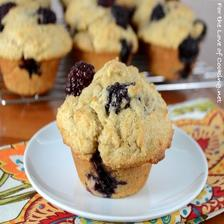

This is a muffin!
Probability: 99.9997%


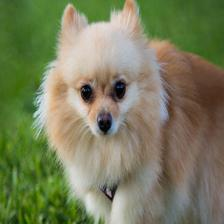

This is a chihuahua!
Probability: 99.9914%


In [4]:
# get interpreted prediction using the predict function
response_muffin = predict(muffin.b)
response_chihuahua = predict(chihuahua.d)

If you downloaded the data, you can also use all of them by adapting the path.

This is how you can have a look at the raw JSON response:

In [5]:
# display JSON response
for key, value in response_muffin.items():
    print(f"{key}: {value}")

print("\n")

for key, value in response_chihuahua.items():
    print(f"{key}: {value}")

class_name: positive
probability: 0.9999966621398926
all_probabilities: {'negative': 3.3225562674488174e-06, 'positive': 0.9999966621398926}


class_name: negative
probability: 0.9999140501022339
all_probabilities: {'negative': 0.9999140501022339, 'positive': 8.600122964708135e-05}


Class `positive` is the muffin, class `negative` is the chihuahua.